#Project of 'Laboratorio di Intelligenza Artificiale'
Nevi Classification with Machine Learninig for automatic diagnosis of melanoma

[![View filled on Github](https://img.shields.io/static/v1.svg?logo=github&label=Repo&message=View%20On%20Github&color=purple)](https://github.com/ValerioSpagnoli/Nevi-Classification/blob/main/Nevi_Classification.ipynb)
[![Open filled In Collab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/1e4YtGOXGq-ZCI5Iun__t99Y4HTTMuQXa?authuser=1#scrollTo=uQbBFaezBVRa)

##Import, mount on Google Drive, definition of variables

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [84]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import optimizer
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler, ConcatDataset, SubsetRandomSampler, random_split
import torchvision
from torchvision.models import resnet
from torchvision.models.resnet import ResNet18_Weights
from torchvision import transforms
from torchvision.transforms import AutoAugment, AutoAugmentPolicy
import torchaudio

import pandas as pd

import os

from skimage import io
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, precision_recall_curve, f1_score, roc_curve, roc_auc_score

import matplotlib.pyplot as plt

import numpy as np

import seaborn as sns

from google.colab import files

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


In [4]:
torch.manual_seed(0)

In [76]:
batch_size = 32
num_epochs = 8
classes = ('benign', 'malignant')

K=5
KFolder = KFold(n_splits=K, shuffle=True, random_state=None)
fold_performance={}

##Class of Dataset and Loader

In [8]:
class ISIC_Dataset(Dataset):
  def __init__(self, csv_file, img_dir, transform=None, data=None, device=None):
    self.img_labels = pd.read_csv(csv_file)
    self.img_dir = img_dir
    self.transform = transform
    self.data = data
    self.code_img = None
    self.device = device

  def __len__(self):
    return len(self.img_labels)

  def __getitem__(self, idx):
    self.code_img = self.img_labels.iloc[idx, 0]
    img_path = os.path.join(self.img_dir, self.code_img) + '.jpg'
    image = io.imread(img_path)

    #benign = 0 malignant = 1
    
    if(self.data == 'Train'):
      label_bm = self.img_labels.iloc[idx, 1]
      label = 0
      if(label_bm == 'malignant'): 
        label = 1

    elif(self.data == 'Test'):
      label = self.img_labels.iloc[idx, 1].astype(np.int64)


    if self.transform:
      image = self.transform(image)

    image.to(self.device)
  
    return image, label

In [10]:
def get_trainset(path_csv = None, path_img = None, batch_size = None, augment = None):
  
  dataset = None

  transform = transforms.Compose([transforms.ToPILImage(),
                                    transforms.Resize((256, 256)),
                                    transforms.ToTensor(),
                                    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])
  
  dataset = ISIC_Dataset(csv_file = path_csv, img_dir = path_img, transform = transform, data = "Train", device = device)
  

  if augment == True:

    transform_aug = transforms.Compose([transforms.ToPILImage(),
                                    transforms.AutoAugment(policy = AutoAugmentPolicy.IMAGENET),
                                    transforms.Resize((256, 256)),
                                    transforms.ToTensor(),
                                    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])
  
    
    dataset_aug = ISIC_Dataset(csv_file = path_csv, img_dir = path_img, transform = transform_aug, data = "Train", device = device)
    
    dataset = ConcatDataset([dataset, dataset_aug])
    
    
  if(dataset == None):
    print("Errore nel setup del dataset.")
    return

  return dataset

In [11]:
def get_testloader(path_csv = None, path_img = None, batch_size = None, balanced = None):

  loader = None
  dataset = None
  transform = None
    
  transform = transforms.Compose([transforms.ToPILImage(),
                                  transforms.Resize((256, 256)),
                                  transforms.ToTensor(),
                                  transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])


  dataset = ISIC_Dataset(csv_file = path_csv, img_dir = path_img, transform = transform, data = "Test", device = device)
  

  if balanced == True:
      
    class_weights = [1, 4]
    sample_weights = [0] * len(dataset)

    for idx, (image, label) in enumerate(dataset):
      class_weight = class_weights[label]
      sample_weights[idx] = class_weight

    sampler = WeightedRandomSampler(sample_weights, num_samples = len(sample_weights), replacement = True)
    
    loader = DataLoader(dataset, batch_size = batch_size, sampler = sampler)

  else:

    loader = DataLoader(dataset, batch_size = batch_size, shuffle = True)


  if(dataset == None or loader == None or (dataset == None and loader == None)):
    print("Errore nel setup del loader.")
    return

  return loader

In [13]:
def stat_loader(data_type = None, loader = None):
  num_benign = 0
  num_malignant = 0

  for i, data in enumerate(loader, 0):
      inputs, labels = data
      inputs, labels = inputs.to(device), labels.to(device)
      for j in range(labels.size()[0]):
        if(labels[j] == 0):
          num_benign += 1
        else:
          num_malignant += 1

  print("Loader shape:", data_type+"_loader: ", num_benign+num_malignant, "\n\n")

  print("Percentage of benign and malignant nevi in ​​the loader:\n")
  print("benign:", num_benign/(num_benign+num_malignant))
  print("malignant:", num_malignant/(num_benign+num_malignant), "\n\n")

  print("About images:\n")
  features, labels = next(iter(loader))
  print(f"Feature batch shape: {features.size()}")
  print(f"Labels batch shape: {labels.size()}", "\n\n")

  print("Printing a batch of images:\n")

  dataiter = iter(loader)
  images, labels = dataiter.next()

  imshow(torchvision.utils.make_grid(images))

  for i in range(0, batch_size):
    if(labels[i]==0):
      print(i, 'benign')
    else:
      print(i, 'malignant')

In [27]:
def stat_dataframe(dataset_path = None):

  df = pd.read_csv(dataset_path)
    
  df_count = len(df.axes[0])

  print("Numero di dati presenti nel dataframe:", df_count, "\n\n")

  df_benign_count = df['benign'].value_counts(normalize=False)

  total_benign = df_benign_count[0]
  total_malignant = df_benign_count[1]
  
  benign_perc = total_benign/df_count * 100
  malignant_perc = total_malignant/df_count * 100

  print("Percentuale di benigni e maligni nel dataframe:\n")
  print("Benign:", benign_perc)
  print("Malignant:", malignant_perc, "\n\n")

  print("Numero di valori nulli del dataset:\n")
  print(df.isna().sum())

  return total_benign, total_malignant

In [15]:
def imshow(img):
    img[0] = img[0]*0.485 + 0.229     # unnormalize
    img[1] = img[1]*0.456 + 0.224
    img[2] = img[2]*0.406 + 0.225
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

##Model, Training and Testing

In [42]:
def get_pos_weight():
  
  df = pd.read_csv('/content/drive/MyDrive/Università/Progetto Lab IAGI/Dataset1/Training/ISBI2016_ISIC_Part3_Training_GroundTruth.csv')
    
  df_count = len(df.axes[0])

  df_benign_count = df['benign'].value_counts(normalize=False)

  total_benign = df_benign_count[0]
  total_malignant = df_benign_count[1]

  pos_weight = torch.from_numpy(np.array([total_malignant/total_benign]))

  return pos_weight

In [79]:
def get_model():
  model =  torchvision.models.resnet18(weights=ResNet18_Weights.DEFAULT)
  for params in model.parameters():
    params.requires_grad_ = False

  nr_filters = model.fc.in_features
  model.fc = nn.Linear(nr_filters, 1)

  model.to(device)

  #pos_weight = get_pos_weight()
  criterion = nn.BCEWithLogitsLoss()
  criterion.to(device)

  optimizer = optim.SGD(model.parameters(), lr = 0.001, momentum = 0.9)
  
  return model, criterion, optimizer

In [53]:
def train_epoch(model = None, device = None, train_loader = None, criterion = None, optimizer = None):

  loss_epoch = 0
  correct_prediction_epoch = 0
  total_prediction_epoch = 0

  model.train()

  for i, data in enumerate(train_loader, 0):

    inputs, labels = data
    inputs, labels = inputs.to(device), labels.to(device)

    optimizer.zero_grad()

    outputs = model(inputs)
    outputs = torch.transpose(outputs,-1,0)[0]
    
    loss = criterion(outputs, labels.float())
  
    loss.backward()
    optimizer.step()

    loss_epoch += loss.item()

    outputs = torch.sigmoid(outputs)

    prediction = []
    target = []

    for j in range(0, labels.size()[0]):
      out = 0 #benign
      if(outputs[j]>=0.5):
        out = 1 #malignant
      
      lab = labels[j]

      prediction.append(out)
      target.append(lab.item())

      if(lab == out):
        correct_prediction_epoch += 1

      total_prediction_epoch += 1
        
  return loss_epoch, correct_prediction_epoch

In [18]:
def validation_epoch(model = None, device = None, val_loader = None, criterion = None, optimizer = None):

  loss_epoch = 0
  correct_prediction_epoch = 0
  total_prediction_epoch = 0

  model.eval()

  with torch.no_grad():

    for i, data in enumerate(val_loader, 0):

      inputs, labels = data
      inputs, labels = inputs.to(device), labels.to(device)

      outputs = model(inputs)
      outputs = torch.transpose(outputs,-1,0)[0]

      loss = criterion(outputs, labels.float())

      loss_epoch += loss.item()

      outputs = torch.sigmoid(outputs) 

      for j in range(0, labels.size()[0]):
        out = 0 #benign
        if(outputs[j]>=0.5):
          out = 1 #malignant
          
        lab = labels[j]

        if(lab == out):
          correct_prediction_epoch += 1

        total_prediction_epoch += 1
      
  return loss_epoch, correct_prediction_epoch

In [78]:
def get_WeightedRandomSampler(dataset):

  num_benign = 0
  num_malignant = 0

  for i in range(len(dataset)):
    image, label = dataset.__getitem__(i)
    if(label == 0):
      num_benign+=1
    else:
      num_malignant+=1

  benign_weights = num_benign/(num_benign+num_malignant)
  malignant_weights = num_malignant/(num_benign+num_malignant)

  class_weights = [benign_weights, malignant_weights]
  sample_weights = [0] * len(dataset)

  for idx, (image, label) in enumerate(dataset):
    class_weight = class_weights[label]
    sample_weights[idx] = class_weight

  sampler = WeightedRandomSampler(sample_weights, num_samples = len(sample_weights), replacement = True)

  return sampler

In [92]:
def training(dataset = None, model = None, device = None, optimizer = None, criterion = None):

  total_train_loss = []
  total_train_acc = []
  total_val_loss = []
  total_val_acc = []

  l = len(dataset)
  val_len = int(l/5)
  train_len = int(l-val_len)

  print("-------------------------------------------------------------------------")                                     
  print('---------------------------- Start Training -----------------------------')
  print("-------------------------------------------------------------------------\n\n")

  for fold in range(K):
  
    print("\n\n-------------------------------- Fold", fold+1, "---------------------------------\n")

    train_set, val_set = random_split(dataset, [train_len, val_len])

    train_sampler = get_WeightedRandomSampler(train_set)

    train_loader = DataLoader(dataset, batch_size=batch_size, sampler=train_sampler)
    val_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    model.to(device)

    history = {'train_loss': [], 'test_loss': [],'train_acc':[],'test_acc':[]}

    for epoch in range(num_epochs):
        train_loss, train_correct = train_epoch(model, device, train_loader, criterion, optimizer)
        val_loss, val_correct = validation_epoch(model, device, val_loader, criterion)

        train_loss = train_loss / len(train_loader.sampler)
        train_acc = train_correct / len(train_loader.sampler) * 100
        val_loss = val_loss / len(val_loader.sampler)
        val_acc = val_correct / len(val_loader.sampler) * 100

        print("Epoch:{}/{} -- Training Loss:{:.3f} - Validation Loss:{:.3f} -- Training Accuracy {:.2f} % - Validation Accuracy {:.2f} %".format(epoch + 1, num_epochs, train_loss, val_loss, train_acc, val_acc),"\n")

        history['train_loss'].append(train_loss)
        history['test_loss'].append(val_loss)
        history['train_acc'].append(train_acc)
        history['test_acc'].append(val_acc)

        total_train_loss.append(train_loss)
        total_train_acc.append(train_acc)
        total_val_loss.append(val_loss)
        total_val_acc.append(val_acc)

    fold_performance['fold{}'.format(fold+1)] = history  

    print("\n\n")

  print("\n\n-------------------------------------------------------------------------")                                     
  print('--------------------------- Finished Training ---------------------------')
  print("-------------------------------------------------------------------------\n\n")

  return total_train_loss, total_train_acc, total_val_loss, total_val_acc

In [20]:
def avarage():
  train_loss_avg, val_loss_avg, train_acc_avg, val_acc_avg = [], [], [], []

  for f in range(1, K+1):

      train_loss_avg.append(np.mean(fold_performance['fold{}'.format(f)]['train_loss']))
      val_loss_avg.append(np.mean(fold_performance['fold{}'.format(f)]['test_loss']))

      train_acc_avg.append(np.mean(fold_performance['fold{}'.format(f)]['train_acc']))
      val_acc_avg.append(np.mean(fold_performance['fold{}'.format(f)]['test_acc']))

  print('Performance of {} fold cross validation'.format(K))
  print("Average Training Loss: {:.3f} \t Average Test Loss: {:.3f} \t Average Training Acc: {:.2f} \t Average Test Acc: {:.2f}".format(np.mean(train_loss_avg), np.mean(val_loss_avg), np.mean(train_acc_avg), np.mean(val_acc_avg)))     

In [23]:
def test(test_loader = None, model = None, criterion = None, optimizer = None):

  model, criterion, optimizer = model, criterion, optimizer

  total_prediction = 0
  correct_prediction = 0

  with torch.no_grad():

    for i, data in enumerate(test_loader, 0):

      inputs, labels = data
      inputs, labels = inputs.to(device), labels.to(device)

      #outputs = net(inputs)
      outputs = model(inputs)
      outputs = torch.sigmoid(outputs) 

      for j in range(0, labels.size()[0]):
        out = 0
        if(outputs[j]>=0.5):
          out = 1

        lab = labels[j]

        if(lab == out):
          correct_prediction += 1

        total_prediction += 1
        
    final_accuracy = round(correct_prediction/total_prediction * 100, 2)

  print("Test Accuracy:", final_accuracy, "%")

  benign_correct = 0
  benign_total = 0
  malignant_correct = 0
  malignant_total = 0

  with torch.no_grad():
      for data in test_loader:
          images, labels = data
          images, labels = images.to(device), labels.to(device)

          outputs = model(images)
          outputs = torch.sigmoid(outputs) 
          
          for i in range(0, labels.size()[0]):
            
            if(labels[i] == 0): # benign
              benign_total += 1
              if(outputs[i]<0.5):
                benign_correct += 1

            elif(labels[i] == 1): # benign
              malignant_total += 1
              if(outputs[i]>=0.5):
                malignant_correct += 1

  print('Accuracy of "benign" on test images: %d %%' % (100 * benign_correct / benign_total))
  print('Accuracy of "malignant" on test images: %d %%' % (100 * malignant_correct / malignant_total))

In [24]:
def metrics(total_train_loss = None, total_train_acc = None, total_val_loss = None, total_val_acc = None):
  Y = []
  Y_hat = []
  X_test = []

  total_train_loss = total_train_loss
  total_train_acc = total_train_acc
  total_val_loss = total_val_loss
  total_val_acc = total_val_acc

  with torch.no_grad():
    for data in test_loader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)

        for i in range(0, labels.size()[0]):
          Y.append(labels[i].item())
          if(torch.sigmoid(outputs[i][0]).item()<0.5):
            Y_hat.append(0)
          else:
            Y_hat.append(1)
        

  #print(Y)
  #print(Y_hat)

  cm = confusion_matrix(Y, Y_hat)
  plt.figure()
  sns.set(font_scale=1.5)
  hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 15}, yticklabels=['0', '1'], xticklabels=['0', '1'])
  plt.title('Confusion Matrix')
  plt.ylabel('Ground Truth')
  plt.xlabel('Prediction')
  plt.show()

  print("Total_train_loss:", total_train_loss)
  print("Total_val_loss:  ", total_val_loss)
  print("Total_train_acc: ", total_train_acc)
  print("Total_val_acc:   ", total_val_acc)
  
  fig = plt.subplot(2, 1, 1)
  plt.plot(total_train_loss, label = 'training loss')
  plt.plot(total_val_loss, label = 'validation loss')
  plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
  plt.title("Training and Validation Loss")

  plt.subplot(2, 1, 2)
  plt.plot(total_train_acc, label = 'training accuracy')
  plt.plot(total_val_acc, label = 'validation accuracy')
  plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
  plt.title("Training and Validation Accuracy")

  plt.subplots_adjust(left=0.1,
                      right=0.9, 
                      bottom=0.1, 
                      top=0.9, 
                      wspace=0.8, 
                      hspace=0.8)

  plt.show()

In [49]:
def test_on_1batch(test_loader = None, model = None):

  dataiter = iter(test_loader)
  images, labels = dataiter.next()

  imshow(torchvision.utils.make_grid(images))
  
  images, labels = images.to(device), labels.to(device)

  outputs = model(images)
  outputs = torch.sigmoid(outputs)

  out = []

  for elem in outputs:
    if elem.item() >= 0.5:
      out.append(1)
    elif elem.item() < 0.5:
      out.append(0)

  print("idx | Ground Truth | Prediction")
  print("----|--------------|-----------")

  for i in range(0, batch_size):
    print(i, "  |" if i < 10 else " |", classes[labels[i]]+"     " if labels[i] == 0 else classes[labels[i]]+"  ", " |", classes[out[i]])

##Nevi Classification

In [ ]:
stat_dataframe()

In [88]:
train_set = get_trainset(path_csv = '/content/drive/MyDrive/Università/Progetto Lab IAGI/Dataset1/Training/ISBI2016_ISIC_Part3_Training_GroundTruth.csv', 
                        path_img = '/content/drive/MyDrive/Università/Progetto Lab IAGI/Dataset1/Training/ISBI2016_ISIC_Part3_Training_Data',
                        batch_size = batch_size, 
                        augment = True)

In [32]:
test_loader = get_testloader(path_csv = '/content/drive/MyDrive/Università/Progetto Lab IAGI/Dataset1/Test/ISBI2016_ISIC_Part3_Test_GroundTruth.csv', 
                              path_img = '/content/drive/MyDrive/Università/Progetto Lab IAGI/Dataset1/Test/ISBI2016_ISIC_Part3_Test_Data',
                              batch_size = batch_size, 
                              balanced = True)

In [86]:
model, criterion, optimizer = get_model()

In [93]:
total_train_loss, total_train_acc, total_val_loss, total_val_acc = training(dataset = train_set, model = model, device = device, optimizer = optimizer, criterion = criterion)

-------------------------------------------------------------------------
---------------------------- Start Training -----------------------------
-------------------------------------------------------------------------




-------------------------------- Fold 1 ---------------------------------

Epoch:1/8 -- Training Loss:0.015 - Validation Loss:0.013 -- Training Accuracy 80.35 % - Validation Accuracy 80.78 % 

Epoch:2/8 -- Training Loss:0.011 - Validation Loss:0.011 -- Training Accuracy 83.19 % - Validation Accuracy 85.22 % 

Epoch:3/8 -- Training Loss:0.010 - Validation Loss:0.010 -- Training Accuracy 86.53 % - Validation Accuracy 86.94 % 

Epoch:4/8 -- Training Loss:0.008 - Validation Loss:0.009 -- Training Accuracy 90.21 % - Validation Accuracy 86.72 % 

Epoch:5/8 -- Training Loss:0.007 - Validation Loss:0.007 -- Training Accuracy 92.36 % - Validation Accuracy 91.56 % 

Epoch:6/8 -- Training Loss:0.006 - Validation Loss:0.007 -- Training Accuracy 94.31 % - Validation Accuracy 9

In [94]:
avarage()

Performance of 5 fold cross validation
Average Training Loss: 0.003 	 Average Test Loss: 0.004 	 Average Training Acc: 96.68 	 Average Test Acc: 94.88


idx | Ground Truth | Prediction
----|--------------|-----------
0   | benign       | benign
1   | benign       | benign
2   | benign       | benign
3   | benign       | benign
4   | benign       | benign
5   | benign       | benign
6   | malignant    | benign
7   | malignant    | malignant
8   | malignant    | benign
9   | malignant    | malignant
10  | benign       | benign
11  | malignant    | benign
12  | benign       | malignant
13  | benign       | benign
14  | malignant    | benign
15  | malignant    | malignant
16  | malignant    | malignant
17  | malignant    | malignant
18  | malignant    | malignant
19  | benign       | benign
20  | benign       | benign
21  | malignant    | benign
22  | benign       | benign
23  | malignant    | benign
24  | malignant    | malignant
25  | malignant    | benign
26  | malignant    | malignant
27  | benign       | benign
28  | malignant    | malignant
29  | benign       | benign
30  | malignant    | benign
31  | benign       | malignant


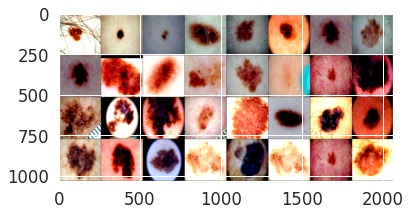

In [95]:
test_on_1batch(test_loader = test_loader, model = model)

In [96]:
test(test_loader = test_loader, model = model, criterion = criterion, optimizer = optimizer)

Test Accuracy: 68.6 %
Accuracy of "benign" on test images: 87 %
Accuracy of "malignant" on test images: 60 %


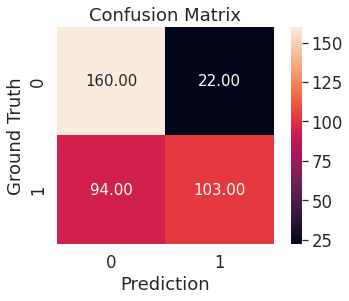

Total_train_loss: [0.014771493193176057, 0.011423430881566471, 0.010167307882673211, 0.007967661895478765, 0.006735577874092592, 0.005710937838173575, 0.004438657067819602, 0.004182456746800906, 0.0035580194658703275, 0.003588484660981016, 0.0027438090053490466, 0.0023618246169967785, 0.002031933848694381, 0.0022333489258825365, 0.0019690156228736873, 0.001972237418845503, 0.0018356184876109991, 0.0023949145775986834, 0.0016778758752884137, 0.0013565618227908594, 0.0014049653626797306, 0.0014144921393987413, 0.0014066096311176402, 0.0013690332080134088, 0.0011414577149682576, 0.0010918309834475318, 0.0011166709092018815, 0.0010413859894874298, 0.0009315407204364116, 0.0008380265295272693, 0.0011830522840480424, 0.001287714372220863, 0.0011466205052177733, 0.0013333094049206315, 0.0008941329693900317, 0.0005998707520322771, 0.0007806921910539839, 0.0008877228599481491, 0.0005837249744217842, 0.0008560272083236164]
Total_val_loss:   [0.01296917423605919, 0.01130407934387525, 0.0101031778

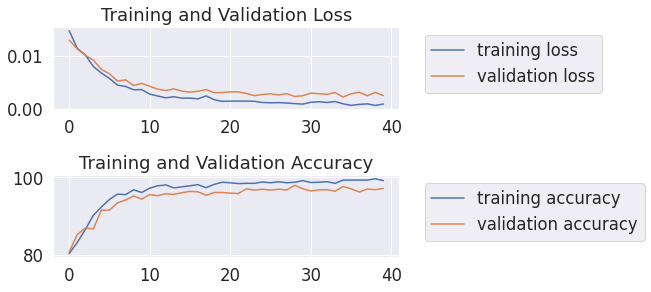

In [97]:
metrics(total_train_loss = total_train_loss, total_train_acc = total_train_acc, total_val_loss = total_val_loss, total_val_acc = total_val_acc)